In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [45]:
img1 = cv2.imread('/kaggle/input/vecros-assignment/data/chess2/im0.png')
img2 = cv2.imread('/kaggle/input/vecros-assignment/data/chess2/im1.png')

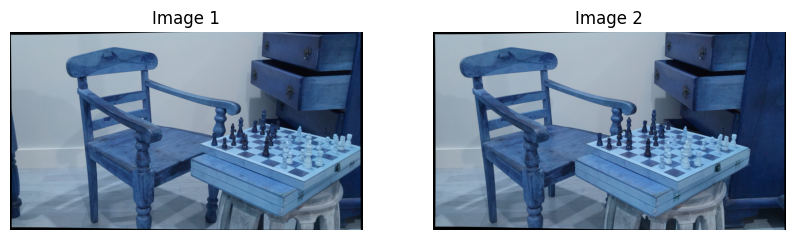

In [46]:
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)  
plt.imshow(img1)
plt.title('Image 1')
plt.axis('off') 
plt.subplot(1, 2, 2)  
plt.imshow(img2)
plt.title('Image 2')
plt.axis('off') 


plt.show()

# Feature detection and Feature Matching

In [47]:
def feature_pairs(matches, kp1, kp2):
    pt_img1 = np.array([kp1[match.queryIdx].pt for match in matches]).reshape(-1, 2)
    pt_img2 = np.array([kp2[match.trainIdx].pt for match in matches]).reshape(-1, 2)
    return pt_img1, pt_img2

def feature_match(image1, image2):
    img1 = image1.copy()
    img2 = image2.copy()
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    img_before = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('feature_match_before_lowes.png', img_before)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    img_after = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('feature_match_after_lowes.png', img_after)

    return good_matches, kp1, kp2

def normalize_points(pts):
    mean_ = np.mean(pts, axis=0)
    u = pts[:, 0] - mean_[0]
    v = pts[:, 1] - mean_[1]
    sd_u = 1 / np.std(pts[:, 0])
    sd_v = 1 / np.std(pts[:, 1])
    Tscale = np.array([[sd_u, 0, 0], [0, sd_v, 0], [0, 0, 1]])
    Ta = np.array([[1, 0, -mean_[0]], [0, 1, -mean_[1]], [0, 0, 1]])
    T = np.dot(Tscale, Ta)
    pt = np.column_stack((pts, np.ones(len(pts))))
    norm_pts = (np.dot(T, pt.T)).T
    return norm_pts, T



# Estimating Fundamental matrix, Essential Matrix and RANSAC

In [49]:
def estimate_F(img1_pts, img2_pts):
    img1_pts, T1 = normalize_points(img1_pts)
    img2_pts, T2 = normalize_points(img2_pts)
    x1 = img1_pts[:, 0]
    y1 = img1_pts[:, 1]
    x1dash = img2_pts[:, 0]
    y1dash = img2_pts[:, 1]
    A = np.zeros((len(x1), 9))
    for i in range(len(x1)):
        A[i] = np.array([x1dash[i]*x1[i], x1dash[i]*y1[i], x1dash[i], y1dash[i]*x1[i], y1dash[i]*y1[i], y1dash[i], x1[i], y1[i], 1])
    U, S, V = np.linalg.svd(A)
    F_est = V[-1, :].reshape(3, 3)
    U, S, V = np.linalg.svd(F_est)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    F = np.dot(T2.T, np.dot(F, T1))
    return F

def ransac(pt1, pt2):
    n_rows = np.array(pt1).shape[0]
    no_iter = 1000
    threshold = 0.05
    inliers = 0
    final_indices = []
    for i in range(no_iter):
        indices = []
        random = np.random.choice(n_rows, size=8)
        img1_8pt = pt1[random]
        img2_8pt = pt2[random]
        F_est = estimate_F(img1_8pt, img2_8pt)
        for j in range(n_rows):
            x1 = pt1[j]
            x2 = pt2[j]
            pt1_ = np.array([x1[0], x1[1], 1])
            pt2_ = np.array([x2[0], x2[1], 1])
            error = np.dot(pt1_.T, np.dot(F_est, pt2_))
            if np.abs(error) < threshold:
                indices.append(j)
        if len(indices) > inliers:
            inliers = len(indices)
            final_indices = indices
            F = F_est
    img1_points = pt1[final_indices]
    img2_points = pt2[final_indices]
    return img1_points, img2_points, F

def estimate_E(K1, K2, F):
    E_est = np.dot(K2.T, np.dot(F, K1))
    U, S, V = np.linalg.svd(E_est)
    S = [1, 1, 0]
    E = np.dot(U, np.dot(np.diag(S), V))
    return E
def decompose_E(E):
    U, S, Vt = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1
    R1 = np.dot(U, np.dot(W, Vt))
    R2 = np.dot(U, np.dot(W.T, Vt))
    t = U[:, 2]
    return [R1, R2, t]

In [50]:
def parse_calibration_file(file_path):
    calib_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            if key.startswith('cam'):
                calib_data[key] = np.array([list(map(float, x.split())) for x in value.strip('[]').split(';')])
            else:
                calib_data[key] = float(value)
    return calib_data

# Traingulation

In [51]:
def point_triangulation(k1, k2, pt1, pt2, R1, C1, R2, C2):
    points_3d = []
    I = np.identity(3)
    C1 = C1.reshape(3, 1)
    C2 = C2.reshape(3, 1)
    P1 = np.dot(k1, np.dot(R1, np.hstack((I, -C1))))
    P2 = np.dot(k2, np.dot(R2, np.hstack((I, -C2))))
    xy = np.hstack((pt1, np.ones((len(pt1), 1))))
    xy_cap = np.hstack((pt2, np.ones((len(pt1), 1))))
    p1, p2, p3 = P1
    p1_cap, p2_cap, p3_cap = P2
    for i in range(len(xy)):
        A = []
        x = xy[i][0]
        y = xy[i][1]
        x_cap = xy_cap[i][0]
        y_cap = xy_cap[i][1]
        A.append((y*p3) - p2)
        A.append((x*p3) - p1)
        A.append((y_cap*p3_cap) - p2_cap)
        A.append((x_cap*p3_cap) - p1_cap)
        A = np.array(A).reshape(4, 4)
        _, _, v = np.linalg.svd(A)
        x_ = v[-1, :]
        x_ = x_ / x_[-1]
        x_ = x_[:3]
        points_3d.append(x_)
    return points_3d

def linear_triangulation(R_Set, T_Set, pt1, pt2, k1, k2):
    R1_ = np.identity(3)
    T1_ = np.zeros((3, 1))
    points_3d_set = []
    for i in range(len(R_Set)):
        points3d = point_triangulation(k1, k2, pt1, pt2, R1_, T1_, R_Set[i], T_Set[i])
        points_3d_set.append(points3d)
    return points_3d_set

def get_RTset(E):
    U, S, V = np.linalg.svd(E, full_matrices=True)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = np.dot(U, np.dot(W, V))
    R2 = np.dot(U, np.dot(W, V))
    R3 = np.dot(U, np.dot(W.T, V))
    R4 = np.dot(U, np.dot(W.T, V))
    T1 = U[:, 2]
    T2 = -U[:, 2]
    T3 = U[:, 2]
    T4 = -U[:, 2]
    R = [R1, R2, R3, R4]
    T = [T1, T2, T3, T4]
    for i in range(len(R)):
        if np.linalg.det(R[i]) < 0:
            R[i] = -R[i]
            T[i] = -T[i]
    return R, T


# Pose Estimation

In [52]:

def extract_pose(E, pt1, pt2, k1, k2):
    R_set, T_set = get_RTset(E)
    pts_3d = linear_triangulation(R_set, T_set, pt1, pt2, k1, k2)
    threshold = 0
    for i in range(len(R_set)):
        R = R_set[i]
        T = T_set[i]
        r3 = R[2]
        pt3d = pts_3d[i]
        num_depth_positive = compute_cheriality(pt3d, r3, T)
        if num_depth_positive > threshold:
            index = i 
            threshold = num_depth_positive
    R_best = R_set[index]
    T_best = T_set[index]
    return R_best, T_best

calibration_data = parse_calibration_file('/kaggle/input/vecros-assignment/data/chess2/calib.txt')
K1 = calibration_data['cam0']
K2 = calibration_data['cam1']

matches, kp1, kp2 = feature_match(img1, img2)
pt_img1, pt_img2 = feature_pairs(matches, kp1, kp2)
img1_points, img2_points, F = ransac(pt_img1, pt_img2)

E = estimate_E(K1, K2, F)

R, T= extract_pose(E, img1_points, img2_points, K1, K2)

print(f"Rotation Matrix:\n{R}")
print(f"Translation Vector:\n{T}")



Rotation Matrix:
[[ 0.9999856  -0.00150618  0.00515137]
 [ 0.00155005  0.99996247 -0.00852415]
 [-0.00513834  0.00853202  0.9999504 ]]
Translation Vector:
[ 0.99858502 -0.00377865  0.0530442 ]


# Error Computation

In [53]:
calib_file_path = '/kaggle/input/vecros-assignment/data/chess2/calib.txt'
calib_data = parse_calibration_file(calib_file_path)
ground_truth_R = np.eye(3) 
ground_truth_t = np.array([[calib_data['baseline']], [0], [0]])


In [54]:
rotation_error = np.linalg.norm(R - ground_truth_R, 'fro')

translation_error = np.linalg.norm(T - ground_truth_t)  

print("\nRotation Error (Frobenius norm):", rotation_error)
print("Translation Error (Euclidean distance):", translation_error)


Rotation Error (Frobenius norm): 0.014250297102929854
Translation Error (Euclidean distance): 215.66499381431348
